# Neural Network

*With PyTorch*

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms, utils

# custom file
from dataset import FaceEmotionsDataset
from transform import Rescale, RandomCrop, ToTensor, Normalize
from network import Net

### Load the data

To load the dataset I use a custom dataset class and custom transforms process our dataset.

In [22]:
data_transform = transforms.Compose([
    Rescale(68),
    RandomCrop(64),
    ToTensor()
])

emotions = ['neutral', 
            'happiness', 
            'surprise', 
            'sadness', 
            'anger', 
            'disgust',
            'fear',
            'contempt']

dataset = FaceEmotionsDataset(csv_file='csv/cleaned_data.csv',
                                          root_dir='img/',
                                          classes=emotions,
                                          transform=data_transform)

dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)

#### Batch preview

0 torch.Size([4, 1, 64, 64]) torch.Size([4])


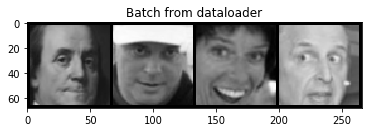

1 torch.Size([4, 1, 64, 64]) torch.Size([4])


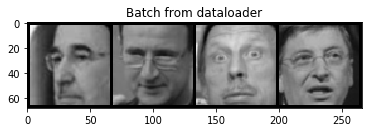

In [3]:
for i_batch, sample_batched in enumerate(dataloader):
    images_batch, emotions_batch = sample_batched['image'], sample_batched['emotion']
    print(i_batch, images_batch.size(),emotions_batch.size())

    # observe 4th batch and stop.
    
    plt.figure()
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')
    plt.show()
    
    if i_batch == 1:
        break
        

### Split the dataset

In [4]:
validation_split = 0.2
shuffle_dataset = True
random_seed = 0

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

test_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

#### Train dataset size

In [5]:
len(train_loader)

2738

#### Test dataset size

In [6]:
len(test_loader)

685

### Define the network

In [7]:
net = Net()

### Define a Loss function and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [10]:
net = net.double()
for epoch in range(2):
    running_loss=0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, emotions = data['image'], data['emotion']

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(images.double())
        loss = criterion(outputs, emotions)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.701
[1,   400] loss: 0.829
[1,   600] loss: 0.752
[1,   800] loss: 0.749
[1,  1000] loss: 0.730
[1,  1200] loss: 0.707
[1,  1400] loss: 0.781
[1,  1600] loss: 0.729
[1,  1800] loss: 0.740
[1,  2000] loss: 0.672
[1,  2200] loss: 0.712
[1,  2400] loss: 0.716
[1,  2600] loss: 0.733
[2,   200] loss: 0.668
[2,   400] loss: 0.690
[2,   600] loss: 0.664
[2,   800] loss: 0.674
[2,  1000] loss: 0.670
[2,  1200] loss: 0.695
[2,  1400] loss: 0.649
[2,  1600] loss: 0.618
[2,  1800] loss: 0.693
[2,  2000] loss: 0.644
[2,  2200] loss: 0.704
[2,  2400] loss: 0.666
[2,  2600] loss: 0.601
Finished Training


### Save our trained model

In [11]:
PATH = './models/network.pth'
torch.save(net.state_dict(), PATH)

### Test the network on the test data

#### Overall accuracy

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))
net = net.double()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, emotion_ids = data['image'], data['emotion']
        outputs = net(images.double())
        _, predicted = torch.max(outputs.data, 1)
        total += emotion_ids.size(0)
        correct += (predicted == emotion_ids).sum().item()

print('Accuracy of the network on the 2740 test images: %d %%' % (100*correct/total))

Accuracy of the network on the 2740 test images: 73 %


#### Performance for each emotion

In [23]:
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for data in test_loader:
        images, emotion_ids = data['image'], data['emotion']
        outputs = net(images.double())
        _, predicted = torch.max(outputs, 1)
        c = (predicted == emotion_ids).squeeze()
        try:
            for i in range(4):
                emotion_id = emotion_ids[i]
                class_correct[emotion_id] += c[i].item()
                class_total[emotion_id] += 1
        except:
            emotion_id = emotion_ids[0]
            class_correct[emotion_id] += c.item()
            class_total[emotion_id] += 1


for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        emotions[i], 100 * class_correct[i] / class_total[i]))

Accuracy of neutral : 71 %
Accuracy of happiness : 91 %
Accuracy of surprise :  0 %
Accuracy of sadness :  0 %
Accuracy of anger :  0 %
Accuracy of disgust :  0 %
Accuracy of  fear :  0 %
Accuracy of contempt :  0 %
